In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
#from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


#pm.help()
#pm.reset()
#pm.init() #debug=True)
#cr_cp = pm.df('cr_cp')
#fe_cp = pm.df('fe_cp')
#cr_cp.info()
#fe_cp.info()

df_jo = pm.df('df_jo')
#df_jo.info()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])

df_jo_cp = df_jo.copy()

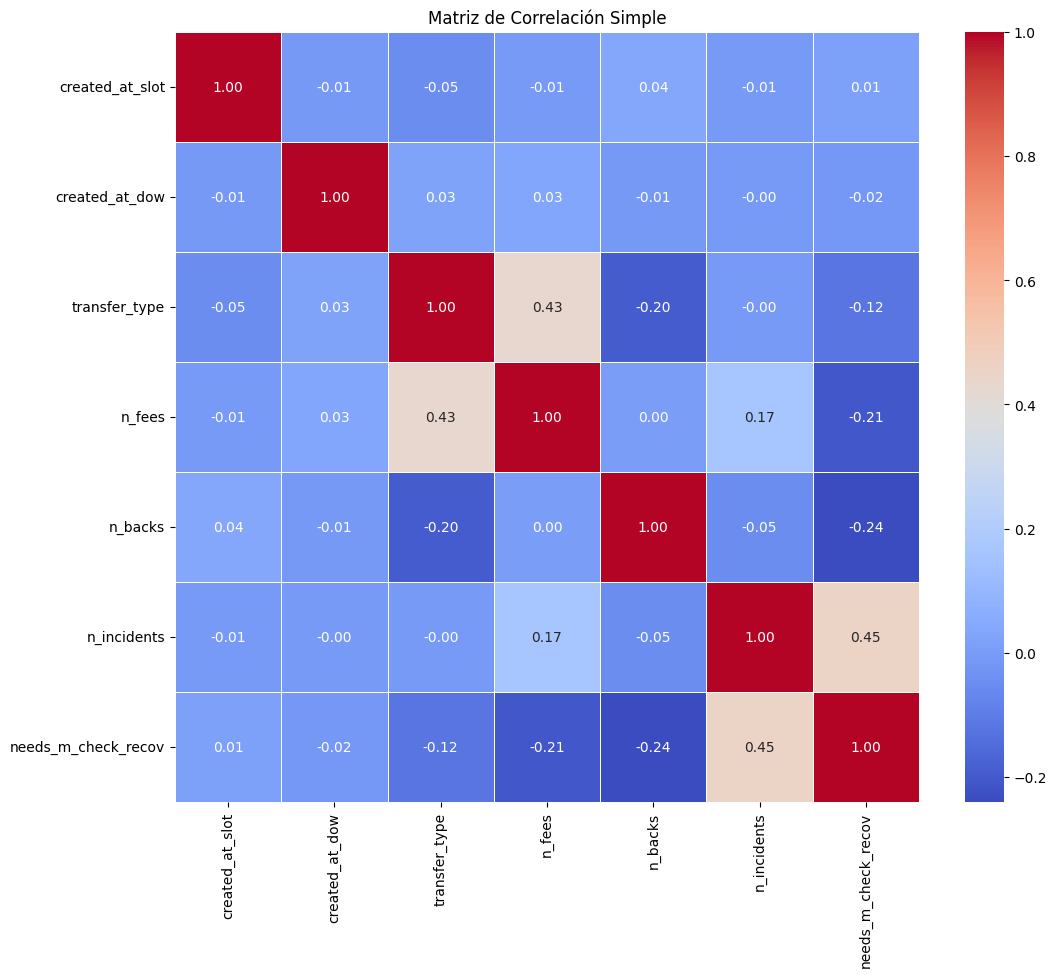

In [34]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas = ['created_at_slot', 'created_at_dow' ,'transfer_type', 'n_fees', 'n_backs','n_incidents', 'needs_m_check_recov']

# Crear un nuevo DataFrame solamente con esas columnas
df_simpl = df_jo_cp[columnas_deseadas]

# Reasignar valores en la columna 'transfer_type'
df_simpl = df_simpl.copy()
df_simpl['transfer_type'] = df_simpl['transfer_type'].map({'regular': 0, 'instant': 1})

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()

In [35]:
#MODELO DE ARBOL DE DESICION

train_X, test_X, train_y, test_y = train_test_split( df_simpl.drop(columns=["needs_m_check_recov"]), df_simpl.needs_m_check_recov, test_size=0.2, random_state=None)

# Se escoge la regresión logística
DT = tree.DecisionTreeClassifier()

# se entrena el modelo con el dataset de entrenamiento
DT.fit(train_X, train_y)

# predice la clase de test
predictions = DT.predict(test_X)


Accuracy: 0.8868982707586851
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      3014
           1       0.88      0.90      0.89      3405

    accuracy                           0.89      6419
   macro avg       0.89      0.89      0.89      6419
weighted avg       0.89      0.89      0.89      6419



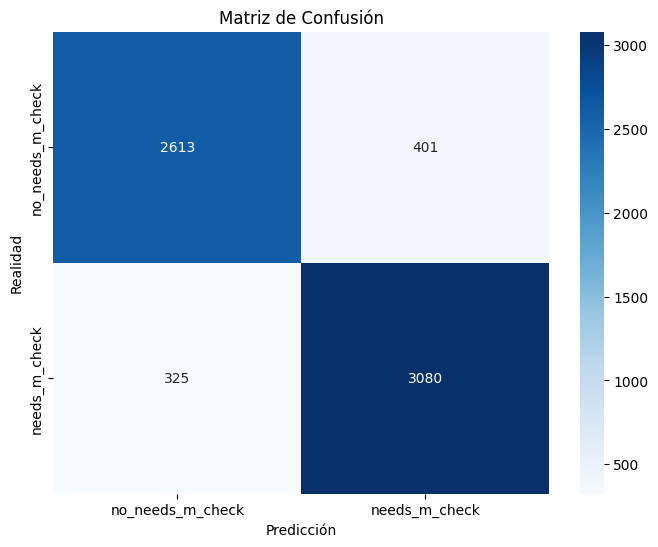

In [36]:
# Evaluate model performance
print("Accuracy:", DT.score(test_X, test_y))  # Accuracy score
print("Classification Report:\n", classification_report(test_y, predictions))  # Classification report

# Column names for confusion matrix labels
columnas = ['no_needs_m_check', 'needs_m_check']  # 0 for No and 1 for Yes

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y, predictions), annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)

# Set labels for the axes
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")
plt.show()

In [37]:
# MODELO RANDOM FOREST

train_X, test_X, train_y, test_y = train_test_split( df_simpl.drop(columns=["needs_m_check_recov"]), df_simpl.needs_m_check_recov, test_size=0.2, random_state=None)

# Se escoge RandomForest
RF = RandomForestClassifier()

# se entrena el modelo con el dataset de entrenamiento
RF.fit(train_X, train_y)

# predice la clase de test
predictions = RF.predict(test_X)


0.8928181959806823
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      2997
           1       0.87      0.94      0.90      3422

    accuracy                           0.89      6419
   macro avg       0.90      0.89      0.89      6419
weighted avg       0.89      0.89      0.89      6419



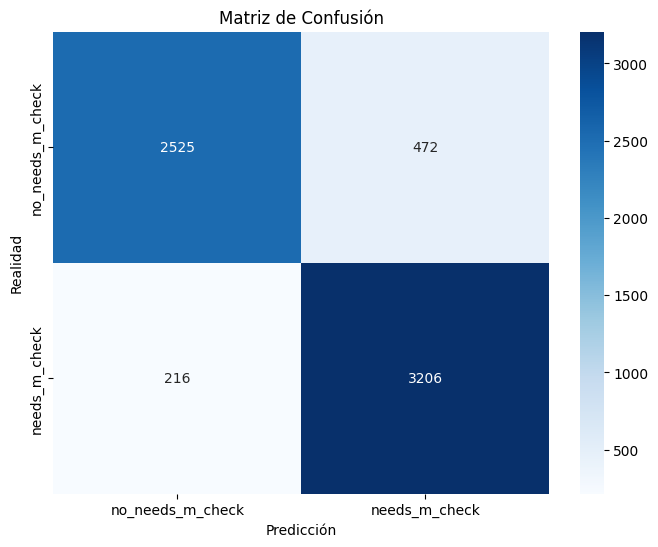

In [38]:
# Evaluate predictions
print(RF.score(test_X, test_y))
print(classification_report(test_y, RF.predict(test_X)))

# Column names for confusion matrix labels
columnas2 = ['no_needs_m_check', 'needs_m_check']  # 0 for No and 1 for Yes

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_y, predictions), annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)

# Set labels for the axes
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.title("Matriz de Confusión")
plt.show()